In [92]:
#!/usr/bin/python
# all code by DBR, updated June 2018

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

#import data and fill in missing values
data=pd.read_csv('charline data - Sheet1.csv')#, sep='\t', names=['origin_id','num','inserted_gene'])
data=data.fillna(0) #replace nan measurements with 0?

rez=600 #resolution for all figures (dpi)


In [93]:
#look at data column titles
data.columns

Index(['Participant ID', 'Treatment Group',
       'Time to ART from estimated date of infection (months)',
       'Length of ART suppression (years)',
       'Integrated HIV DNA TN (copies/million CD4 T cells)',
       'Integrated HIV DNA TSCM (copies/million CD4 T cells)',
       'Integrated HIV DNA TCM (copies/million CD4 T cells)',
       'Integrated HIV DNA TTM (copies/million CD4 T cells)',
       'Integrated HIV DNA TEM (copies/million CD4 T cells)',
       'Integrated HIV DNA Terminallydifferentiated (copies/million CD4 T cells)',
       'Cellassociated HIV RNA TN (copies/million CD4 T cells)',
       'Cellassociated HIV RNA TSCM (copies/million CD4 T cells)',
       'Cellassociated HIV RNA TCM (copies/million CD4 T cells)',
       'Cellassociated HIV RNA TTM (copies/million CD4 T cells)',
       'Cellassociated HIV RNA TEM (copies/million CD4 T cells)',
       'Cellassociated HIV RNA Terminallydifferentiated (copies/million CD4 T cells)',
       'Contribution HIV DNA reservoir

In [94]:
#split into 4 cohorts, early, late, short and long ART, this doubles up patients
early=[3693,2641,2609,2647,2531,2664,2606,2454,2661,2522]
late=[1473,1408,1602,3632,1756,1597,2610,2026,2168,2013,2185,2046,2274,2208]
short=[3693,2641,2609,2647,2531,2664,2606,1473,1408,1602,3632,1756,1597,2610]
long=[2454,2661,2522,2026,2168,2013,2185,2046,2274,2208]

cohorts=[early,late,short,long] #list for all cohorts

cohort_names=['Early','Late','Short','Long'] #cohort names
cohort_style=['-','--',':','-.'] #linestyle for each cohort

ind_DNA=data.columns.get_loc('Integrated HIV DNA TN (copies/million CD4 T cells)') #index for integrated DNA the first subtype
ind_hl=data.columns.get_loc('HalfLife TN (days)') #index for Halflife of the first subtype
ind_PS=data.columns.get_loc('Pool size TN (cells/ml whole blood)') #index for Halflife of the first subtype
#ind_prop=data.columns.get_loc('Contribution HIV DNA reservoir TN') #index for integrated DNA the first subtype

sub_names=['$T_N$','$T_{SCM}$','$T_{CM}$','$T_{EM}$','$T_{TTM}$','$T_{TD}$'] #names for subtypes
sub_color=['black','dimgray','gray','darkgray','silver','lightgray']

num_subtypes=len(sub_names) #number of subtypes 


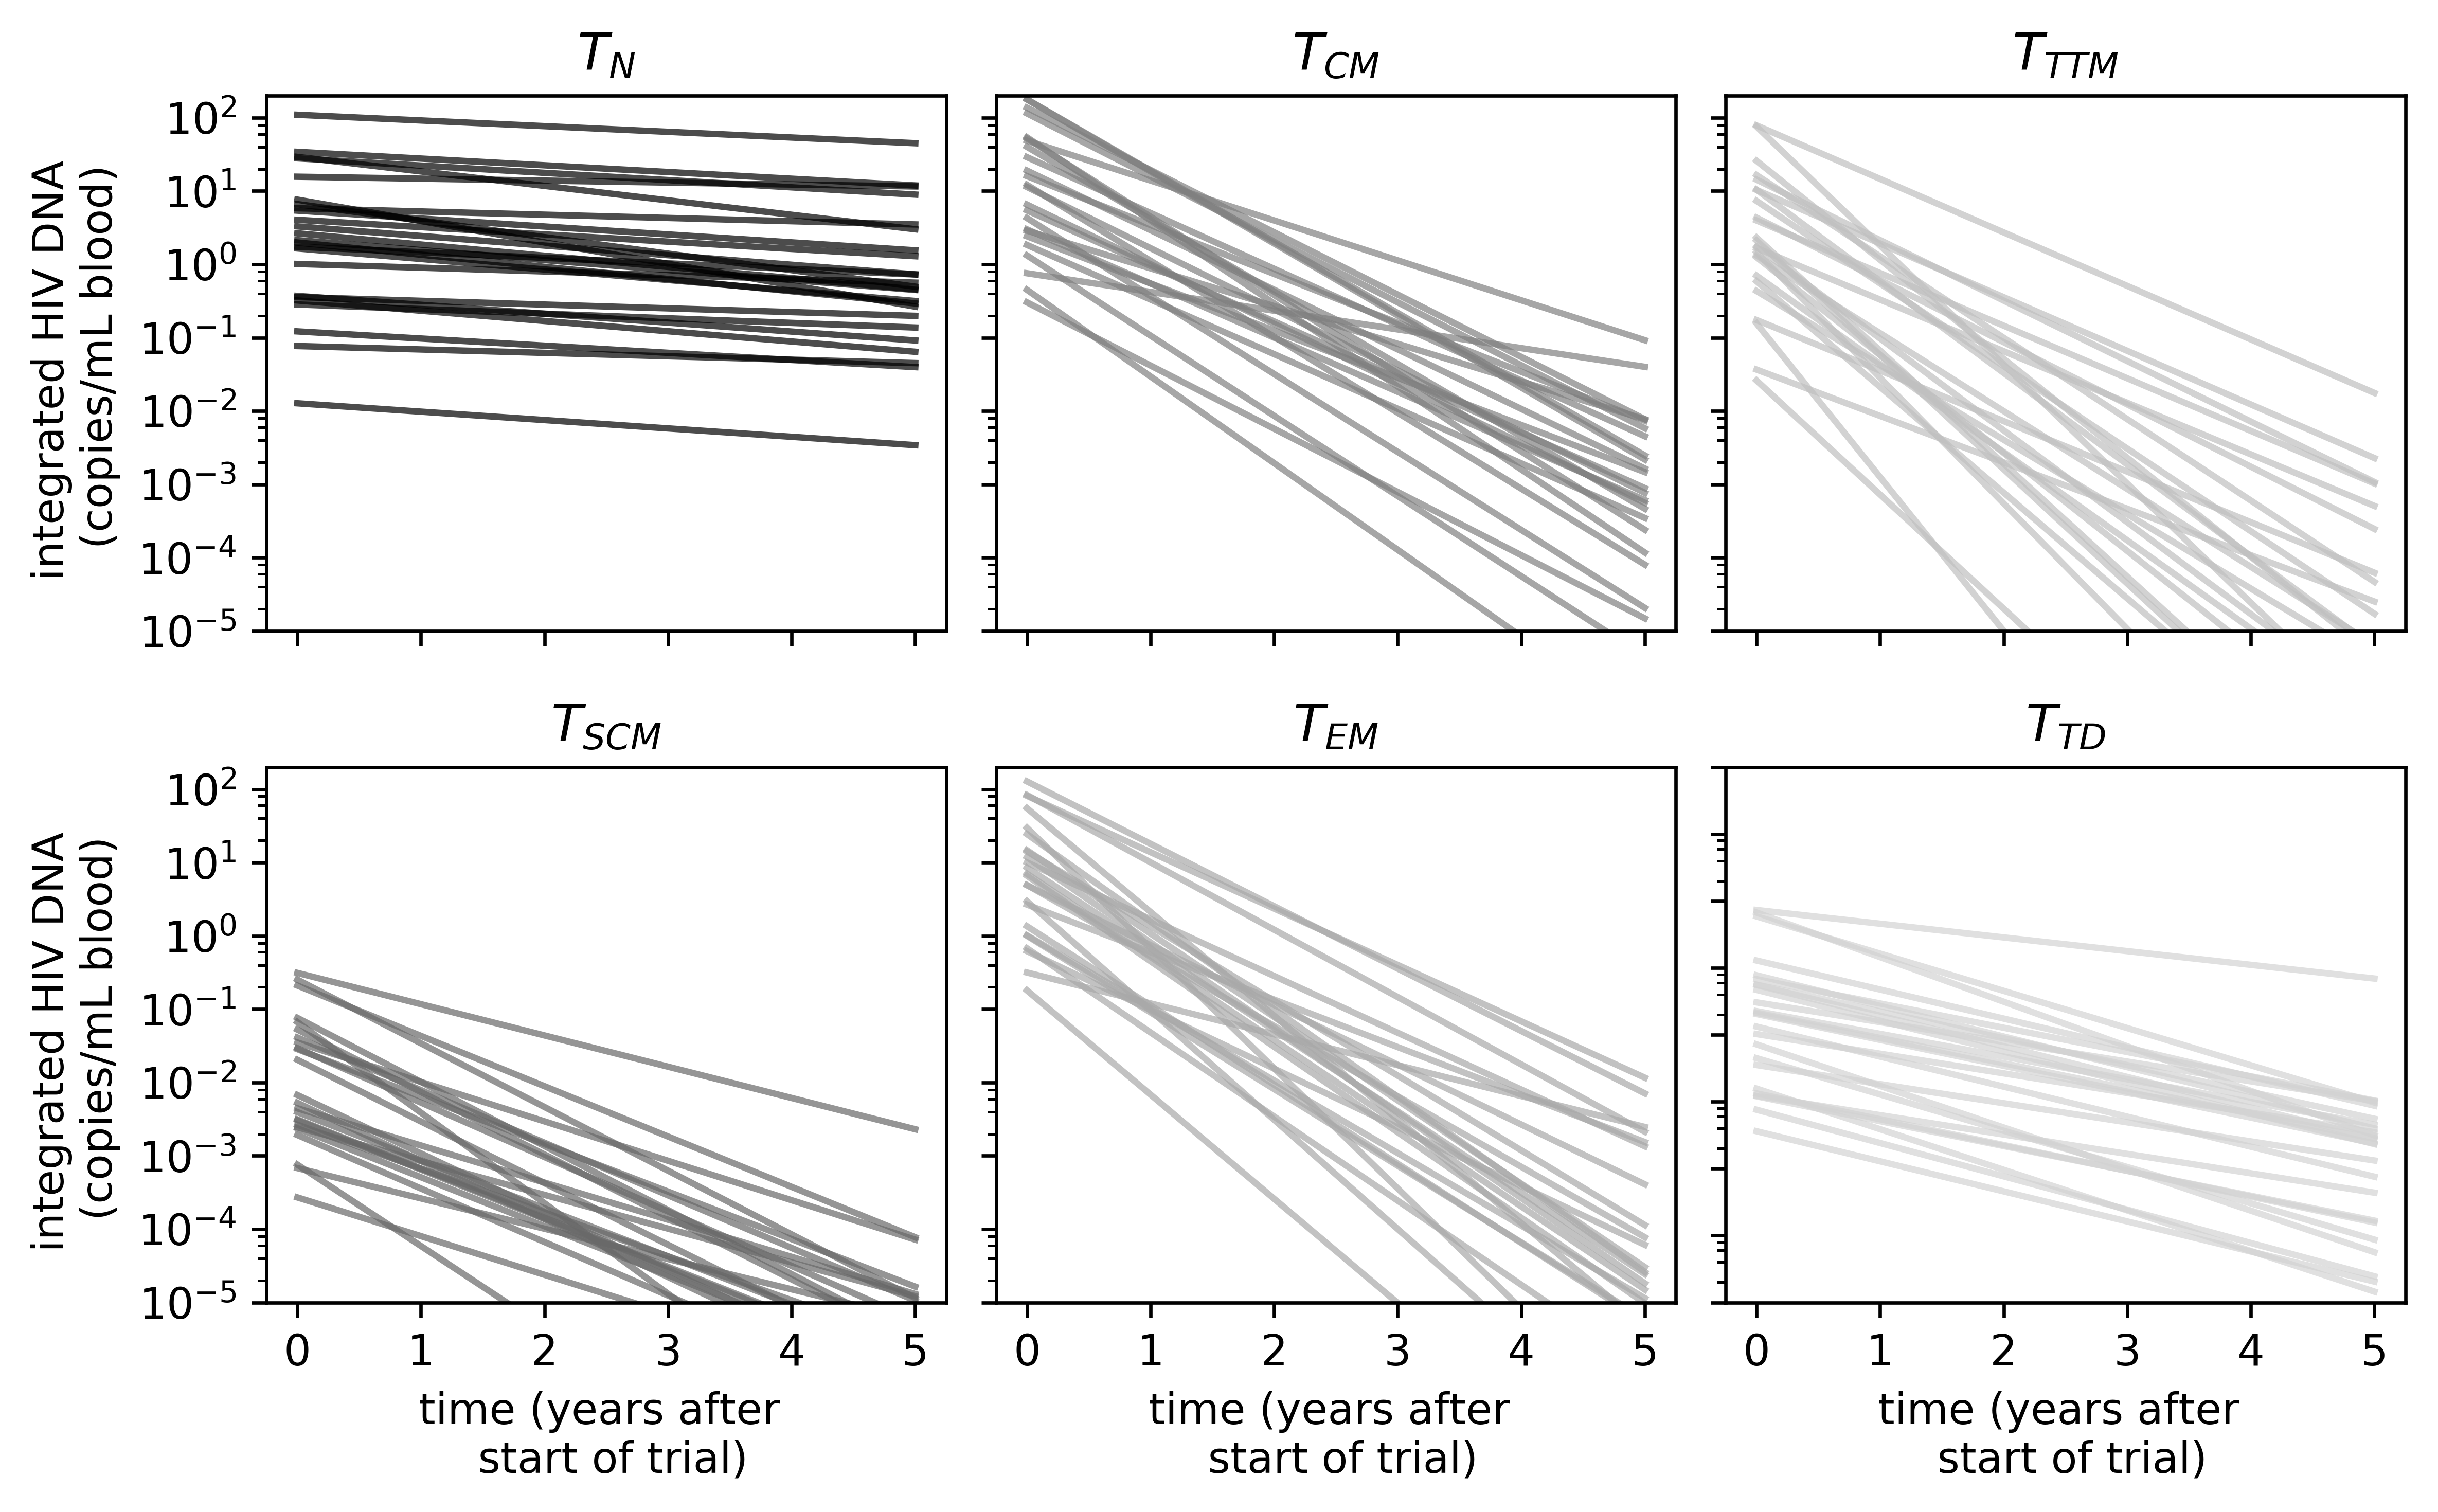

In [101]:
#by subsets in terms of Pool size

fig,axarr=plt.subplots(2,3,sharex=True,sharey=True,figsize=(8,5),dpi=rez)
tY=5 #number of years to simulate
tsim=np.linspace(0,365*tY,1e4) #simulation time in days

#loop over all patients
for pat in range(len(data)):
    pat_data=np.array(data.iloc[pat])#collect that participants information
    ARTdur=pat_data[3]
            
    #calculate the latent HIV DNA population of each participant using all subsets separately
    for sub in range(num_subtypes):
        hl=pat_data[ind_hl+sub]
        Ls=pat_data[ind_DNA+sub]/1000*pat_data[ind_PS+sub] #DNA by subtype and pool size, in copies/mL
        ths=np.log(2)/hl #the clearance rate of that subset
        Lsim=Ls*np.exp(-ths*tsim)
        
        #plot each subset
        ax=axarr[sub%2][int(sub/2)]
        ax.semilogy(tsim/365,Lsim,color=sub_color[sub],alpha=0.7)
        ax.set_title(sub_names[sub])

for i in range(3):
    axarr[1][i].set_xlabel('time (years after \n start of trial)')

ax.set_ylim([1e-5,2e2])
ax.set_xticks(range(6))
ax.set_yticks(np.logspace(-5,3,9))
axarr[0][0].set_ylabel('integrated HIV DNA \n (copies/mL blood)')
axarr[1][0].set_ylabel('integrated HIV DNA \n (copies/mL blood)')
plt.tight_layout()
plt.savefig('charlineA.pdf')        

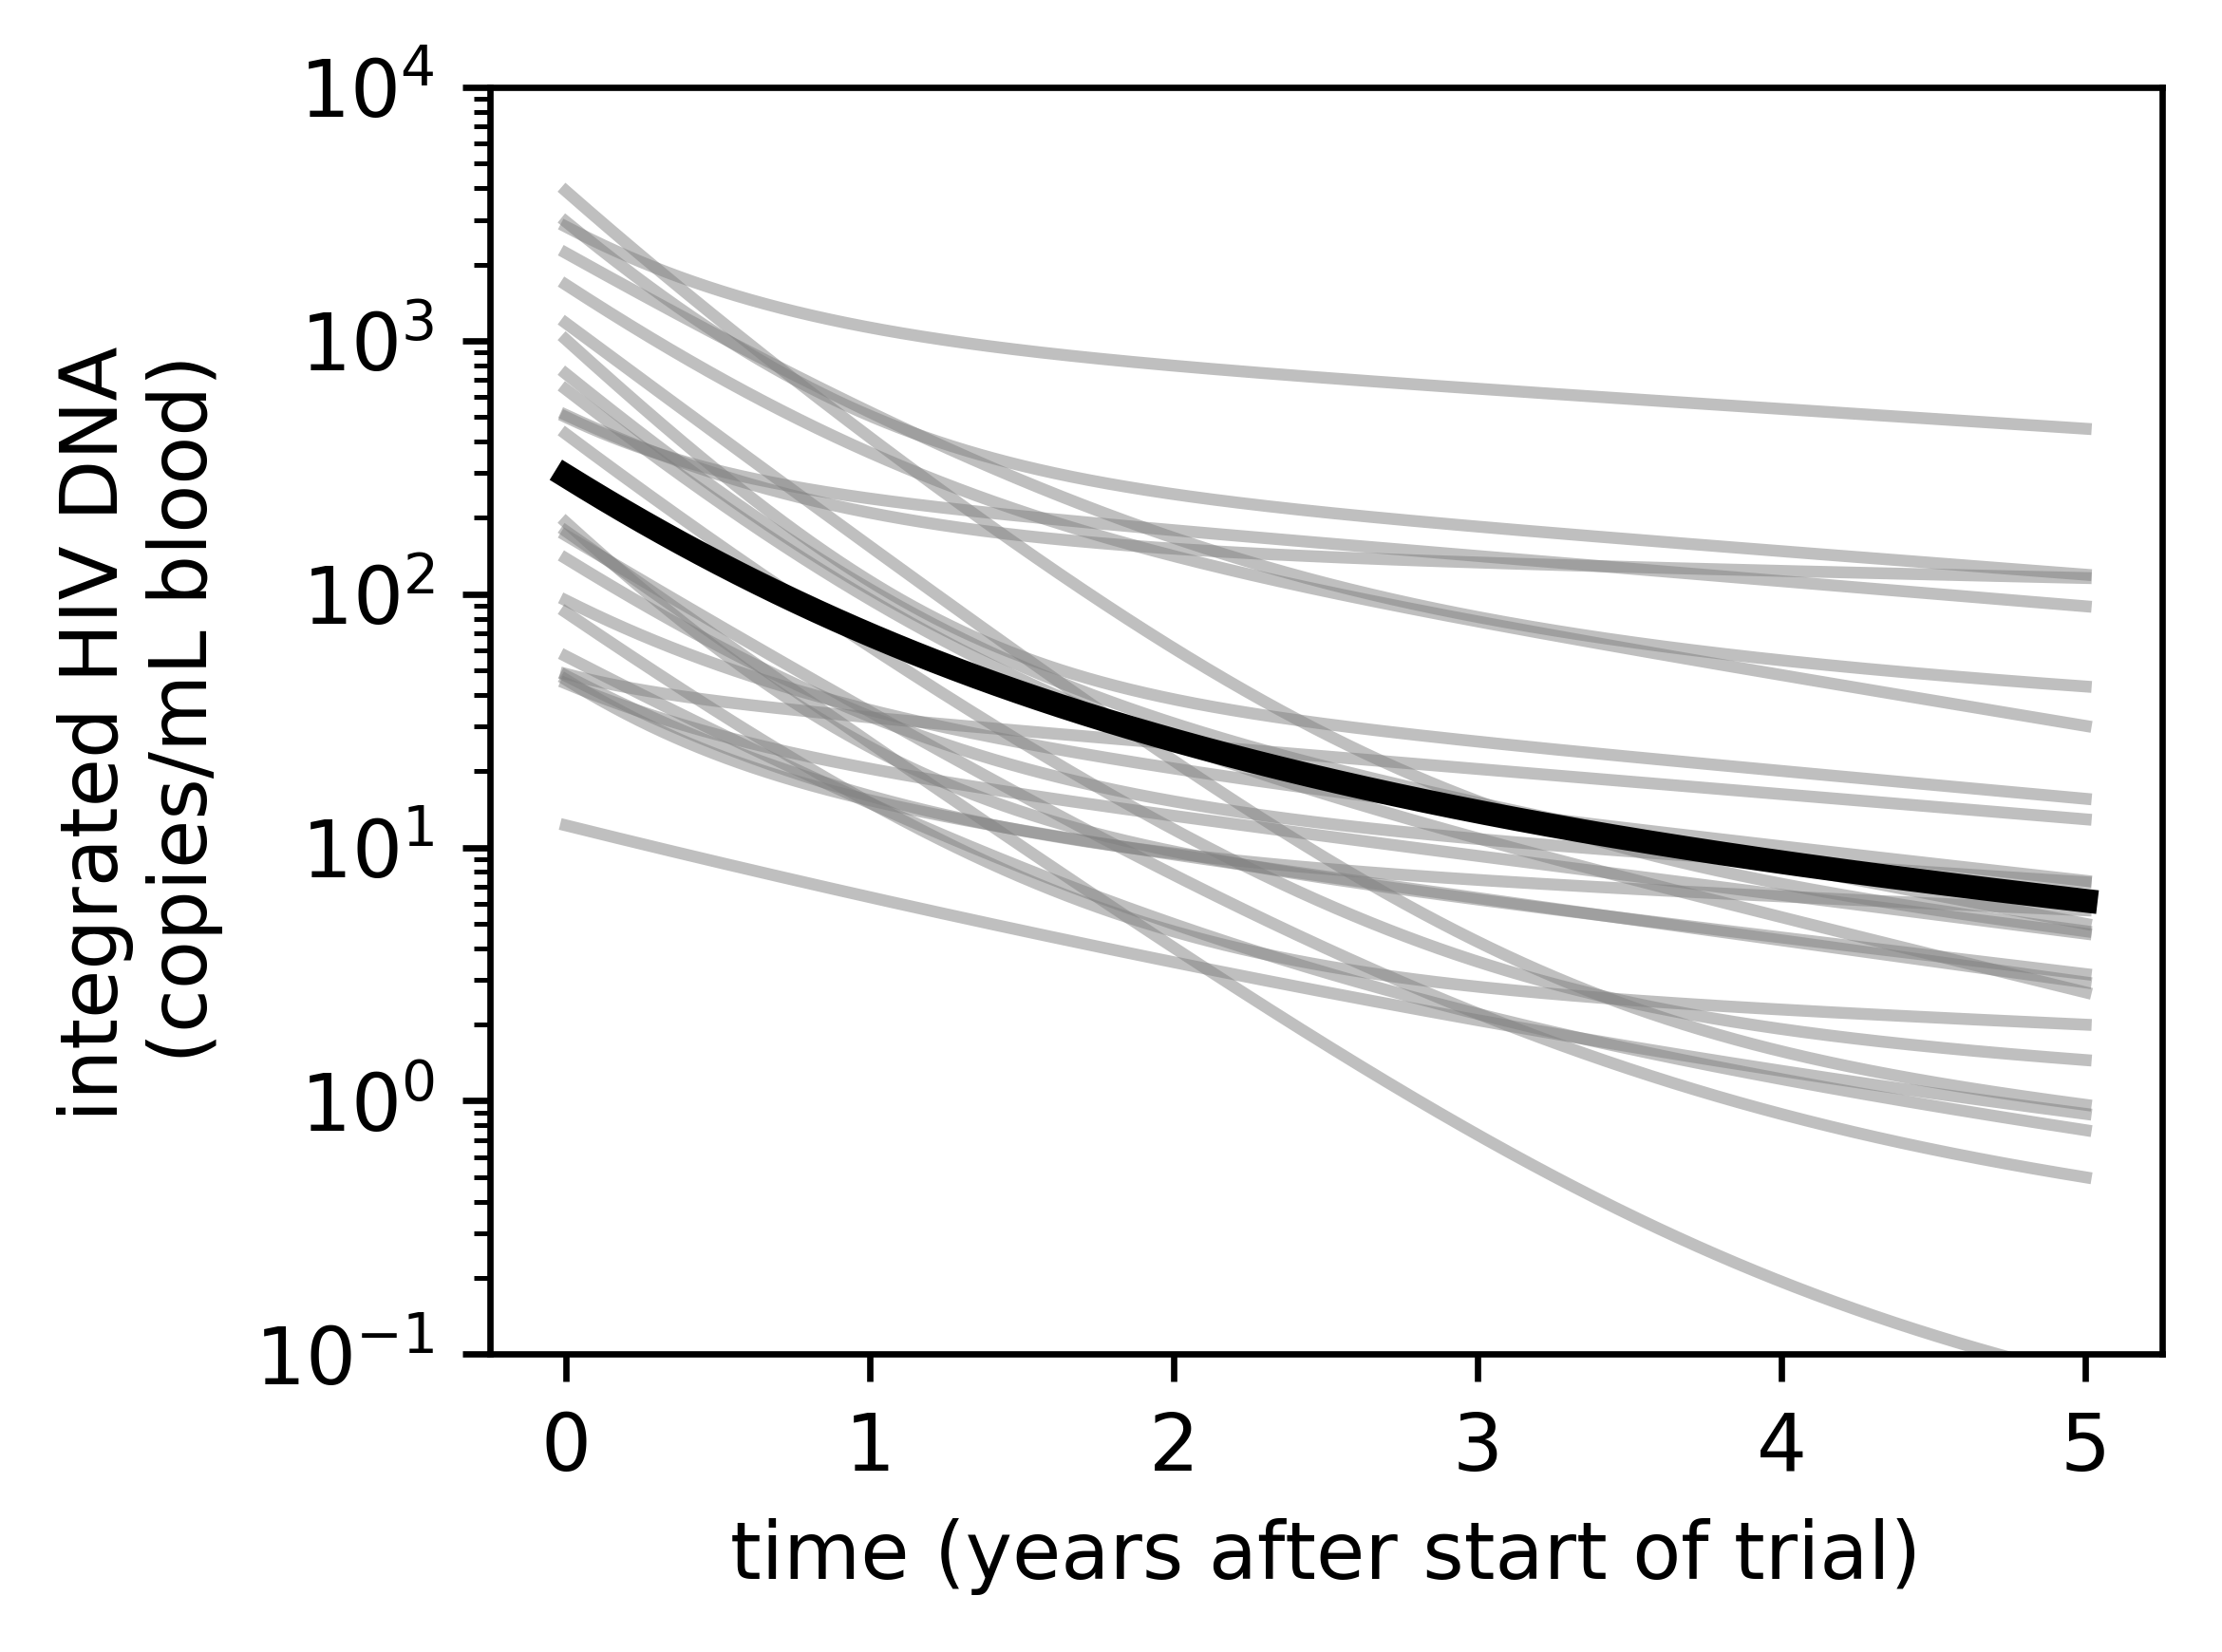

In [110]:
#simulated reservoir decay assuming exponential decay of each subtype, ALL COHORTS ON ONE
plt.figure(figsize=(4,3),dpi=rez)
tY=5 #number of years
tsim=np.linspace(0,365*tY,1e4) #simulation time in days

L=np.zeros([len(data),len(tsim)])
for pat in range(len(data)):
    pat_data=np.array(data.iloc[pat])#collect that participants information

    Lsim=0
    for sub in range(num_subtypes):
        Ls=pat_data[ind_DNA+sub]/100*pat_data[ind_PS+sub] #DNA by subtype in cells per mL
        ths=np.log(2)/pat_data[ind_hl+sub] #the clearance rate of that subset
        Lsim+=Ls*np.exp(-ths*tsim) #sum over the cell types
    L[pat,:]=np.log10(Lsim)
    lS,=plt.semilogy(tsim/365,Lsim,alpha=0.5,color='gray')

plt.semilogy(tsim/365,10**np.mean(L,0),alpha=1,color='k',lw=3)

plt.ylim([1e-1,1e4])
plt.xticks(range(6))
plt.yticks(np.logspace(-1,4,6))
plt.xlabel('time (years after start of trial)')
plt.ylabel('integrated HIV DNA \n (copies/mL blood)')
plt.tight_layout()
plt.savefig('charlineB.pdf')        

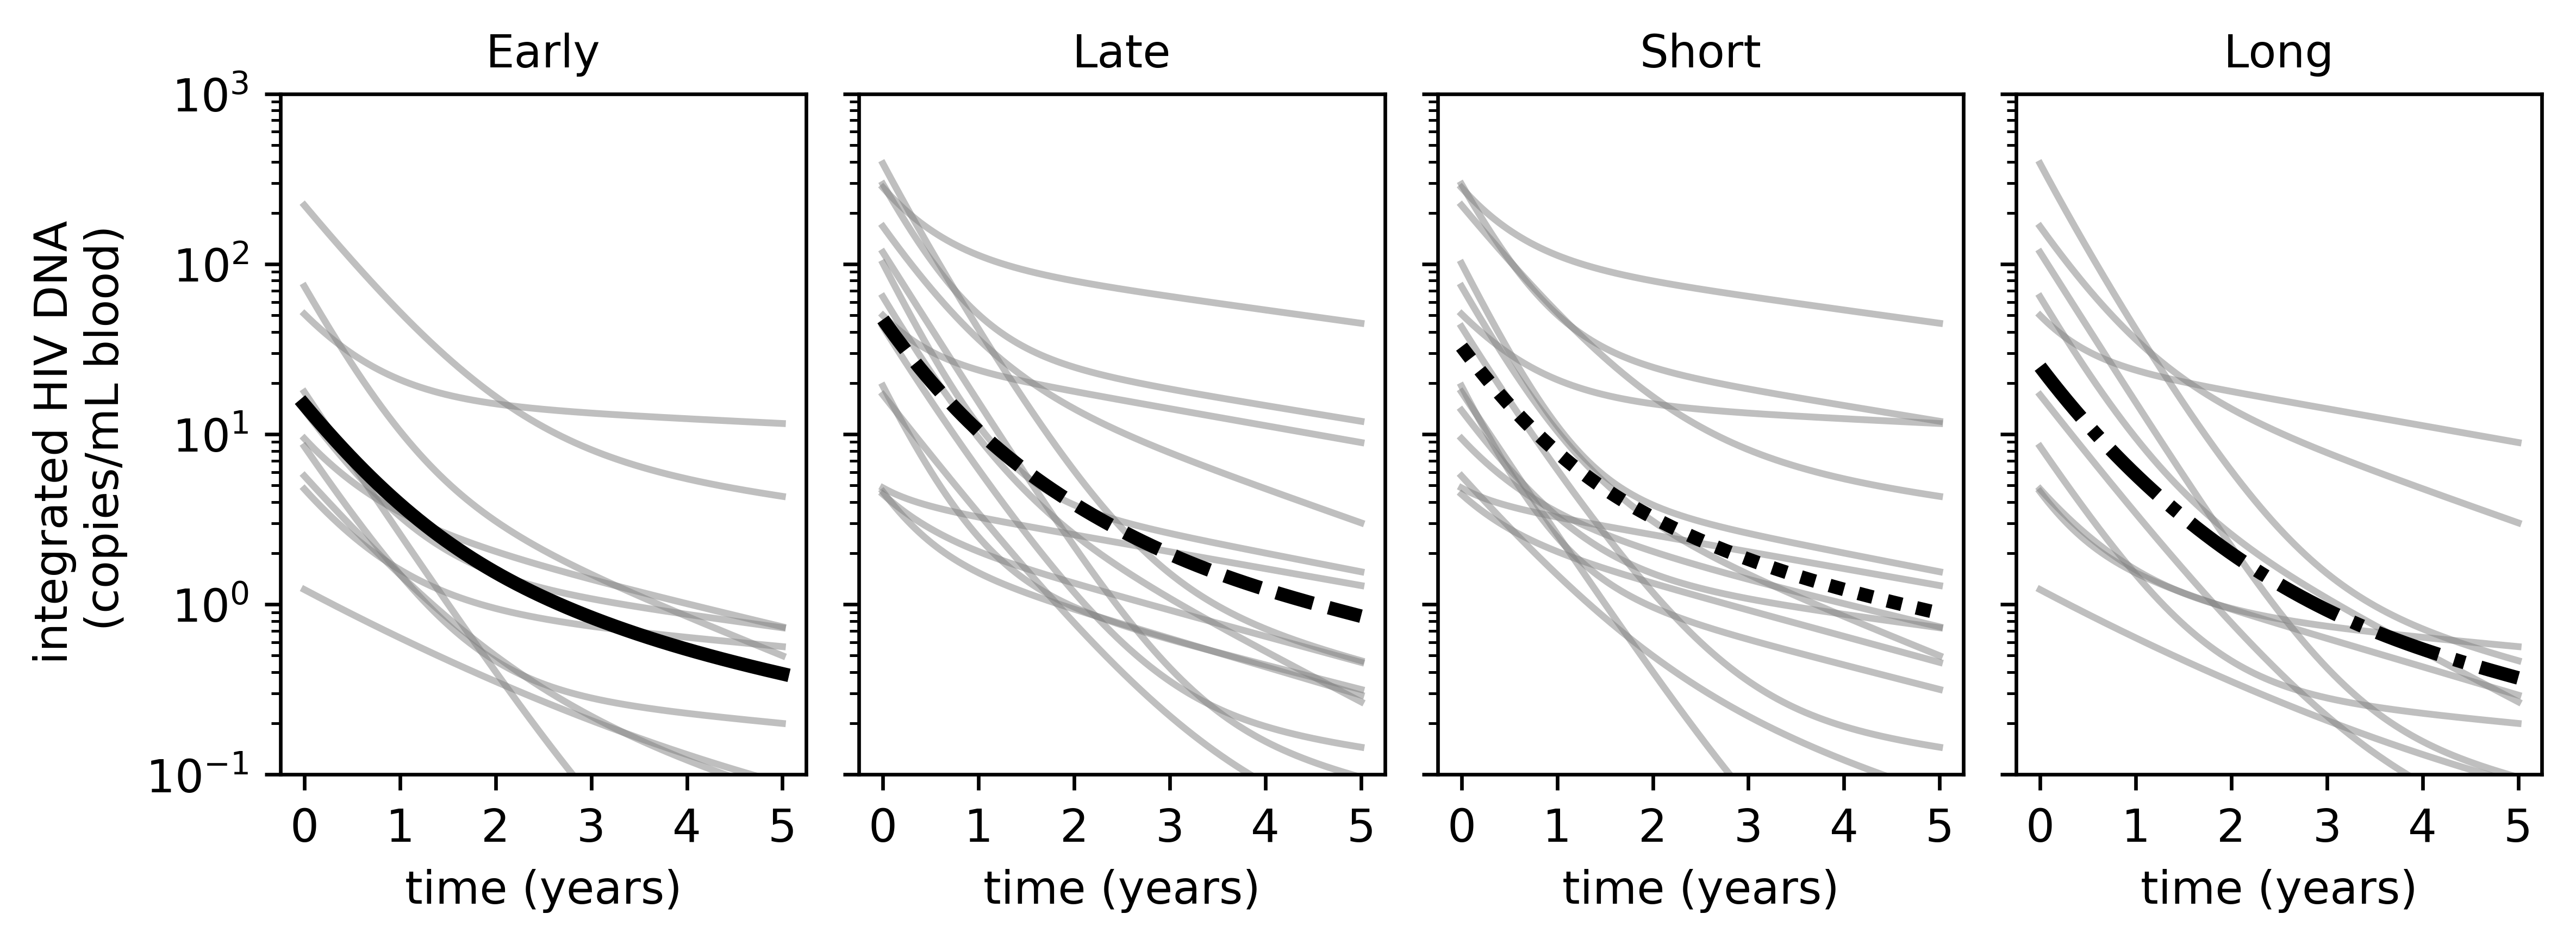

In [114]:
#simulated reservoir decay assuming exponential decay of each subtype
fig,axarr=plt.subplots(1,4,sharex=True,sharey=True,figsize=(8,3),dpi=rez)
tY=5 #number of years
tsim=np.linspace(0,365*tY,1e4) #simulation time in days

L=[]
for cohort in range(len(cohorts)):
    Lcohort=[]
    ax=axarr[cohort]
    for pat in range(len(cohorts[cohort])):
        pat_data=np.array(data[data['Participant ID']==cohorts[cohort][pat]])[0] #collect that participants information
         
        Lsim=0
        for sub in range(num_subtypes):
            Ls=pat_data[ind_DNA+sub]/1000*pat_data[ind_PS+sub] #DNA by subtype in cells per mL
            ths=np.log(2)/pat_data[ind_hl+sub] #the clearance rate of that subset
            Lsim+=Ls*np.exp(-ths*tsim) #sum over the cell types
        ax.semilogy(tsim/365,Lsim,color='gray',alpha=0.5)
        Lcohort.append(np.log10(Lsim))
    Lavg=np.mean(Lcohort,0)
    ax.semilogy(tsim/365,10**Lavg,color='k',ls=cohort_style[cohort],lw=3)
    ax.set_xlabel('time (years)')
    ax.set_title(cohort_names[cohort],fontsize=10)
    L.append(Lavg)

ax.set_xticks(range(6))
axarr[0].set_ylim([1e-1,1e3])
axarr[0].set_ylabel('integrated HIV DNA \n (copies/mL blood)')
plt.tight_layout()
plt.savefig('charlineC.pdf')        

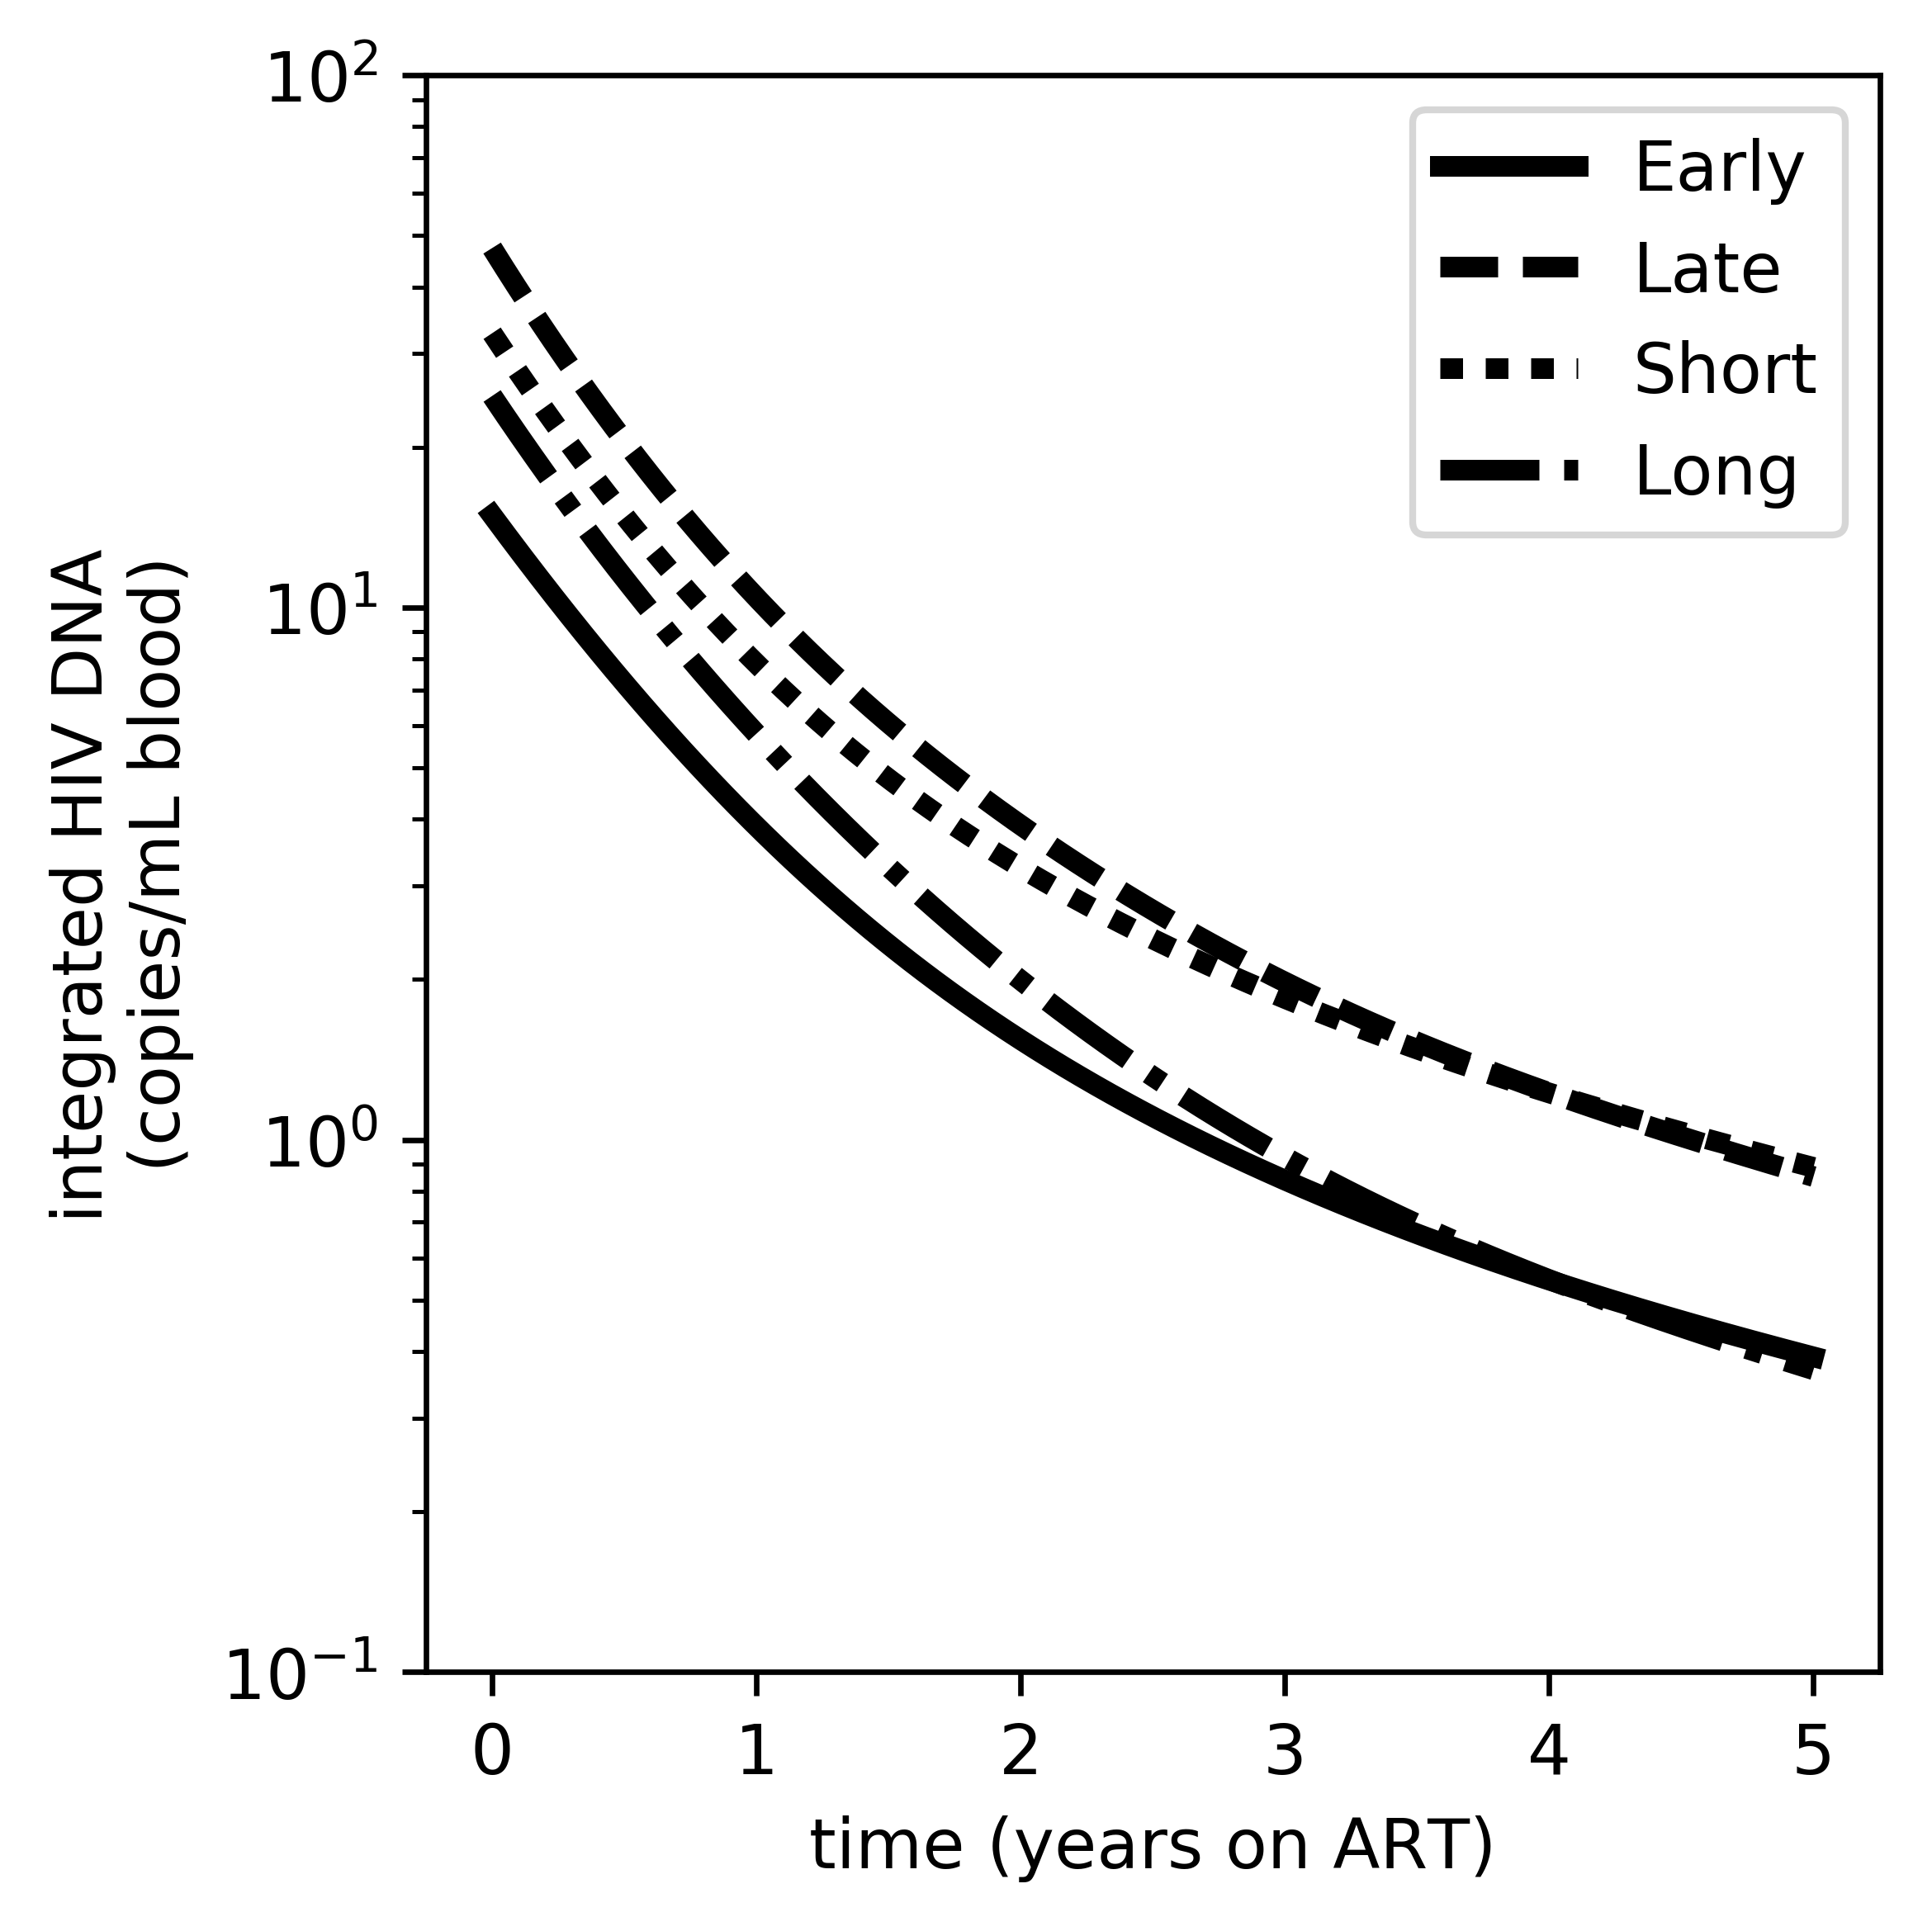

In [116]:
plt.figure(figsize=(4,4),dpi=rez)
for cohort in range(len(cohorts)):
    plt.semilogy(tsim/365,10**L[cohort],color='k',ls=cohort_style[cohort],lw=3)
plt.legend(cohort_names,fontsize=10)
plt.ylim([1e-1,1e2])
plt.xlabel('time (years on ART)')
plt.ylabel('integrated HIV DNA \n (copies/mL blood)')
plt.tight_layout()
plt.savefig('charlineD.pdf') 

In [143]:
for i in range(4):
    print(cohort_names[i],'t_{1/2}=',np.round(-np.log(2)/st.linregress(tsim/365*12,np.array(L[i]))[0],2),'months') #linear regression over whole interval in months, print the halflife
    

Early t_{1/2}= 28.05 months
Late t_{1/2}= 25.61 months
Short t_{1/2}= 29.08 months
Long t_{1/2}= 23.72 months


In [135]:
            ths=np.log(2)/pat_data[ind_hl+sub] #the clearance rate of that subset


array([  0.00000000e+00,   6.00060006e-03,   1.20012001e-02, ...,
         5.99879988e+01,   5.99939994e+01,   6.00000000e+01])

In [136]:
60*12

720